In [108]:
#Paquetes
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from scipy.optimize import minimize
import sys

In [109]:
flag_runlocal  = False    # "False" para ejecutar en google colab
flag_useserver = True    # "False" para ejecutar con conexión a internet via proxy

In [110]:
if flag_runlocal:
    # ---> Ejecución local
    pathBayesInfer = ''
    if flag_useserver:
        from ConfigProxy import proxy
        # Set the proxy with authentication
        import os
        os.environ['http_proxy'] = proxy
        os.environ['https_proxy'] = proxy

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/Alledar/BayesInfer.git
    pathBayesInfer = '/content/BayesInfer/'

sys.path.append(pathBayesInfer+'02_Libraries')
import DSGEstuff as DG
import KFstuff as KF
from GeneralComplements import HP

fatal: destination path 'BayesInfer' already exists and is not an empty directory.


- Modelo simple de economía cerrrada
- Solo el ciclo económico es relevante en la dinámica económica

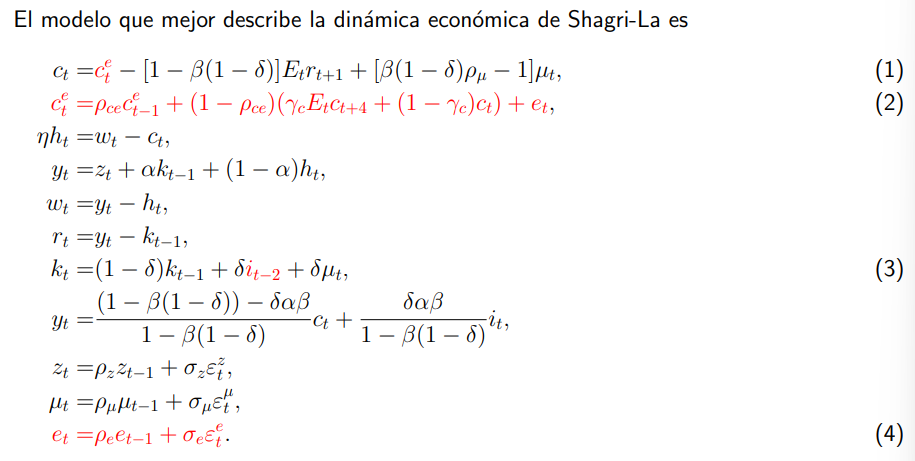

In [111]:
# Calibración inicial
ALPHA_0 = 0.33
BETA_0    = 0.99
DELTA_0   = 0.025
ETA_0     = 0.5
RHOz_0    = 0.95
RHOu_0    = 0.95
SIGMAz_0  = 0.1
SIGMAu_0  = 0.1
#PROP_INA = 0.30
#PROP_RACION= 0.70
#desv_e= 0.20
RHOce_0= 0.3
GAMMAc_0=0.7
RHOe_0=0.2
SIGMAe_0=2.00




param_0 = np.array([[ALPHA_0],[BETA_0],[DELTA_0],[ETA_0],[RHOz_0],[RHOu_0],[SIGMAz_0],[SIGMAu_0],[RHOce_0],[GAMMAc_0],[RHOe_0],[SIGMAe_0]])

In [112]:
def RBCveranoBCRP(param):

    # Unpack parameters
    ALPHA   = param[0].item()
    BETA    = param[1].item()
    DELTA   = param[2].item()
    ETA     = param[3].item()
    RHOz    = param[4].item()
    RHOu    = param[5].item()
    SIGMAz  = param[6].item()
    SIGMAu  = param[7].item()
    RHOce   = param[8].item()
    GAMMAc  = param[9].item()
    RHOe    = param[10].item()
    SIGMAe  = param[11].item()

    # fyp
    fyp = np.zeros((11,6))
    # Ecuación 1
    fyp[0,5] = -(1 - BETA*(1-DELTA))
    # Ecuación 2
    fyp[1,1] = (1 - RHOce) * GAMMAc


    # fy
    fy = np.zeros((11,6))
    # Ecuación 1
    fy[0,1] = -1
    # Ecuación 2
    fy[1,1] = (1 - RHOce) * (1-GAMMAc)
    # Ecuación 3
    fy[2,1] = -1
    fy[2,3] = -ETA
    fy[2,4] = 1
    # Ecuación 4
    fy[3,0] = -1
    fy[3,3] = (1 - ALPHA)
    # Ecuación 5
    fy[4,0] = 1
    fy[4,3] = -1
    fy[4,4] = -1
    # Ecuación 6
    fy[5,0] = 1
    fy[5,5] = -1
    # Ecuación 7
    fy[6,2] = DELTA
    # Ecuación 8
    fy[7,0] = -1
    fy[7,1] = ( (1 - BETA*(1-DELTA)) - DELTA*ALPHA*BETA ) / (1 - BETA*(1-DELTA))
    fy[7,2] = (DELTA*ALPHA*BETA) / (1 - BETA*(1-DELTA))


    # fxp
    fxp = np.zeros((11,5))
    # Ecuación 1
    fxp[0,1] = 1
    # Ecuación 2
    fxp[1,1] = -1
    # Ecuación 7
    fxp[6,0] = -1
    # Ecuación 9
    fxp[8,2] = -1
    # Ecuación 10
    fxp[9,3] = -1
    # Ecuación 11
    fxp[10,4] = -1


    # fx
    fx = np.zeros((11,5))
    # Ecuación 1
    fx[0,3] = (BETA*(1-DELTA)*RHOu - 1)
    # Ecuación 2
    fx[1,1] = RHOce
    fx[1,4] = 1
    # Ecuación 4
    fx[3,0] = ALPHA
    fx[3,2] = 1
    # Ecuación 6
    fx[5,0] = -1
    # Ecuación 7
    fx[6,0] = (1-DELTA)
    fx[6,3] = DELTA
    # Ecuación 9
    fx[8,2] = RHOz
    # Ecuación 10
    fx[9,3] = RHOu
    # Ecuación 11
    fx[10,4] = RHOe


    # Matriz Lambda para los estados (autorregresivos)
    Lambda = np.zeros((3,3))
    Lambda[0,0] = RHOz
    Lambda[1,1] = RHOu
    Lambda[2,2] = RHOe

    # Matriz Eta para las innovaciones
    Eta = np.zeros((5,3))
    # Ajusta las posiciones según tu modelo
    Eta[2,0] = SIGMAz
    Eta[3,1] = SIGMAu
    Eta[4,2] = SIGMAe

    return {
        'fyp': fyp,
        'fy': fy,
        'fxp': fxp,
        'fx': fx,
        'Lambda': Lambda,
        'Eta': Eta
    }

In [113]:
modelo = dict()
modelo['SLER'] = RBCveranoBCRP(param_0)

In [114]:
modelo = DG.SolveDSGE(modelo)

In [115]:
modelo['solución']['gx']

array([[  0.23392231,  -0.43762738,   1.77380668,   0.63628233,
         -1.78863869],
       [  0.44902162,   0.54213541,   0.04140366,  -0.78823035,
          2.21577629],
       [ -0.46615452,  -3.62642987,   7.41220318,   5.27259802,
        -14.82167954],
       [ -0.14339954,  -0.65317519,   1.15493535,   0.94967512,
         -2.66960998],
       [  0.37732185,   0.21554781,   0.61887133,  -0.31339279,
          0.88097129],
       [ -0.76607769,  -0.43762738,   1.77380668,   0.63628233,
         -1.78863869]])

Data

In [116]:

url = "https://raw.githubusercontent.com/AlvaroMoran03/inferencia-bayesiana/main/Segundo%20trabajo-20250124/DataDSGE.xlsx"

Data = pd.read_excel(url, engine='openpyxl')

In [117]:
modelo = dict()
modelo['SLER'] = RBCveranoBCRP(param_0) #dar inputs necesarios

Data

In [118]:
Data.columns

Index(['Unnamed: 0', 'y', 'ii', 'ce'], dtype='object')

In [119]:
Data.rename(columns={"Unnamed: 0": "date"}, inplace=True)

mask = ~Data["date"].astype(str).str.startswith(("2023", "2024"))
Data = Data[mask]

In [120]:
# Filtro HP
Ybar,gdp = HP(Data['y'].to_numpy(),1600)
Ibar,inv = HP(Data['ii'].to_numpy(),1600)
Cbar,con = HP(Data['ce'].to_numpy(),1600)

In [121]:
data = np.c_[gdp,inv,con]


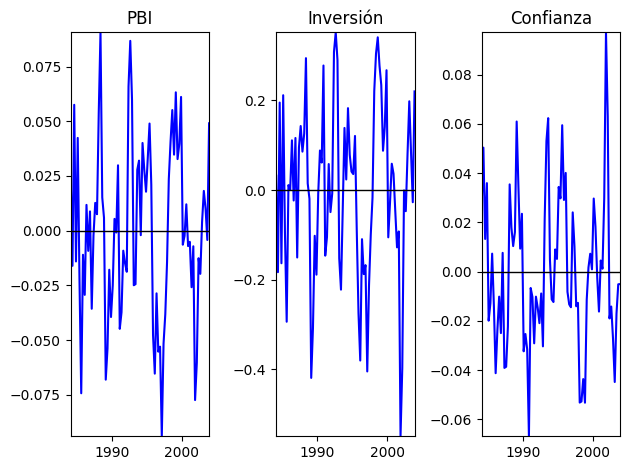

In [122]:
# Dibujando la data
tlab = 1984+np.array(list(range(gdp.shape[0])))/4+0.125
fig, axs = plt.subplots(1,3)
axs[0].plot(tlab,gdp,'b')
axs[0].axhline(0, color='k', lw=1)
axs[0].autoscale(enable=True, axis='both', tight=True)
axs[0].set_title('PBI')
axs[1].plot(tlab,inv,'b')
axs[1].axhline(0, color='k', lw=1)
axs[1].autoscale(enable=True, axis='both', tight=True)
axs[1].set_title('Inversión')
axs[2].plot(tlab,con,'b')
axs[2].axhline(0, color='k', lw=1)
axs[2].autoscale(enable=True, axis='both', tight=True)
axs[2].set_title('Confianza')
plt.tight_layout()

In [123]:
def GenMeasureMat(solvedmodel,measureerror2): ##Define una función para devolver las que necesitamos de la ecuacion de medida
    n = solvedmodel['SLER']['dimensiones']['n'] ## solo deberiamos cambiar la medida (para lo que tenemos datos)

    Z = np.zeros(shape=(3,n))
    Z[0,0] = 1
    Z[1,2] = 1
    Z[2,7] = 1


    H = np.zeros(shape=(3,3))
    H[0,0] = measureerror2[0].item()
    H[1,1] = measureerror2[1].item()
    H[2,2] = measureerror2[1].item()


    solvedmodel['REE']['Z']=Z
    solvedmodel['REE']['H']=H

    return solvedmodel

## 2 y 3

In [124]:
modelo = DG.SolveDSGE(modelo)

In [125]:
MEsdgdp = np.std(gdp)*0
MEsdinv = np.std(inv)*0
MEsdcon = np.std(con)*0



In [126]:
modelo = DG.get_StatesMat(modelo,True)
modelo = GenMeasureMat(modelo,np.array([[MEsdgdp**2],[MEsdinv**2],[MEsdcon**2]]))

Los nombres en LaTeX, tal cual, serían:

\[
\rho_{ce},
\quad
\gamma_c,
\quad
\rho_e,
\quad
100 \times \sigma_e.
\]

In [127]:
PRIORmean = np.array([0.33,  #ALPHA
                      1.00,  #tBETA
                      0.03,  #DELTA
                      0.50,  #ETA
                      0.60,  #RHOz
                      0.60,  #RHOu
                      2.00,  #tSIGMAz
                      2.00,  #tSIGMAu
                      0.50,   #RHOce
                      0.70, #GAMMAc
                      0.50, #RHOe
                      2.00/100, #tSIGMAe
                      ])

PRIORvar = np.array([0.20,  #ALPHA
                     1.00,  #tBETA
                     0.015, #DELTA
                     0.50,  #ETA
                     0.20,  #RHOz
                     0.20,  #RHOu
                     2.00,  #tSIGMAz
                     2.00, #tSIGMAu
                      0.2,   #RHOce
                      0.20, #GAMMAc
                      0.20, #RHOe
                      2.00, #tSIGMAe
                     ])
def get_minuslogprior(theta):
    from math import log
    # unpack theta
    ALPHA   = theta[0]
    tBETA   = theta[1]
    DELTA   = theta[2]
    ETA     = theta[3]
    RHOz    = theta[4]
    RHOu    = theta[5]
    SIGMAz100  = theta[6]
    SIGMAu100  = theta[7]
    RHOce   = theta[8]
    GAMMAc  = theta[9]
    RHOe    = theta[10]
    SIGMAe  = theta[11]
    # compute pdf
    pALPHA = DG.BetaPDF(ALPHA,PRIORmean[0],PRIORvar[0])
    ptBETA = DG.InvGammaPDF(tBETA,PRIORmean[1],PRIORvar[1])
    pDELTA = DG.BetaPDF(DELTA,PRIORmean[2],PRIORvar[2])
    pETA = DG.InvGammaPDF(ETA,PRIORmean[3],PRIORvar[3])
    pRHOz = DG.BetaPDF(RHOz,PRIORmean[4],PRIORvar[4])
    pRHOu = DG.BetaPDF(RHOu,PRIORmean[5],PRIORvar[5])
    pSIGMAz100 = DG.InvGammaPDF(SIGMAz100,PRIORmean[6],PRIORvar[6])
    pSIGMAu100 = DG.InvGammaPDF(SIGMAu100,PRIORmean[7],PRIORvar[7])
    pRHOce = DG.BetaPDF(RHOce,PRIORmean[8],PRIORvar[8])
    pGAMMAc = DG.BetaPDF(GAMMAc,PRIORmean[9],PRIORvar[9])
    pRHOe = DG.BetaPDF(RHOe,PRIORmean[10],PRIORvar[10])
    pSIGMAe100 = DG.InvGammaPDF(SIGMAe,PRIORmean[11],PRIORvar[11])
    ## Evaluar los beta evaluados en  los puntos
    # Joint
    pALL = pALPHA*pETA*pRHOz*pRHOu*pSIGMAz100*pSIGMAu100*pDELTA*ptBETA*pRHOce*pGAMMAc*pRHOe*pSIGMAe100
    eps = np.finfo(float).eps
    if pALL <= eps:
        pALL = np.finfo(float).eps

    return -log( pALL )

##Uso el prior



In [128]:
def SLERfun(theta):
    # unpack theta
    ALPHA   = theta[0].item()
    BETA    = 1/(1+theta[1].item()/100)
    DELTA   = theta[2].item()
    ETA     = theta[3].item()
    RHOz    = theta[4].item()
    RHOu    = theta[5].item()
    SIGMAz  = theta[6].item()/100
    SIGMAu  = theta[7].item()/100
    RHOce   = theta[8].item()
    GAMMAc  =theta[9].item()
    RHOe    =theta[10].item()
    SIGMAe  =theta[11].item()/100
    # Parametros estimado
    # Ninguno

    # pack params
    param = np.ndarray(shape=(12,1))
    param[0] = ALPHA
    param[1] = BETA
    param[2] = DELTA
    param[3] = ETA
    param[4] = RHOz
    param[5] = RHOu
    param[6] = SIGMAz
    param[7] = SIGMAu
    param[8] = RHOce
    param[9] = GAMMAc
    param[10] = RHOe
    param[11] = SIGMAe
    return RBCveranoBCRP(param) #te devuelve las mtrices que caracterizan el estado espacio

In [129]:
def Measurefun(modelo): return GenMeasureMat(modelo,np.array([[MEsdgdp**2],[MEsdinv**2],[MEsdcon**2]]))

In [130]:
theta_0=np.ndarray(shape=(12,1))
theta_0[0] = ALPHA_0
theta_0[1] = 100*(1/BETA_0-1)
theta_0[2] = DELTA_0
theta_0[3] = ETA_0
theta_0[4] = RHOz_0
theta_0[5] = RHOu_0
theta_0[6] = SIGMAz_0*100
theta_0[7] = SIGMAu_0*100
theta_0[8] = RHOce_0
theta_0[9] = GAMMAc_0
theta_0[10] = RHOe_0
theta_0[11] = SIGMAe_0*100
theta_0

array([[3.30000000e-01],
       [1.01010101e+00],
       [2.50000000e-02],
       [5.00000000e-01],
       [9.50000000e-01],
       [9.50000000e-01],
       [1.00000000e+01],
       [1.00000000e+01],
       [3.00000000e-01],
       [7.00000000e-01],
       [2.00000000e-01],
       [2.00000000e+02]])

<ipython-input-127-c308aac71cb9>:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -log( pALL )


No existe equilibrio local
No existe equilibrio local


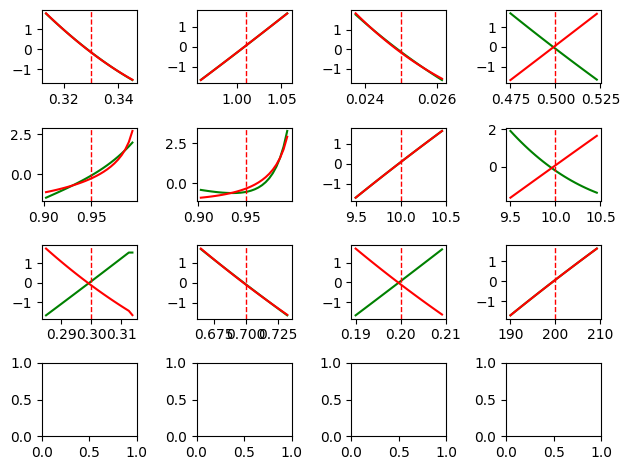

In [131]:
x0 = theta_0
xup = x0*1.05
xdw = x0*0.95
def minusllk(theta,data): return DG.get_minusloglike(theta,data,SLERfun,Measurefun)
def minuslps(theta,data): return DG.get_minuslogpost(theta,data,SLERfun,Measurefun,get_minuslogprior)
others = {'fcn1':minuslps}
KF.modecheck(minusllk, x0, xup, xdw, data, others)

In [132]:
row_coefs = np.array(['ALPHA','100(1/BETA-1)','DELTA','ETA','RHOz','RHOu','100xSIGMAz','100xSIGMAu','RHOce','GAMMAc','RHOe','SIGMAe'])
col_names = np.array(['x0','xopt: moda','sd(xopt)'])
starting = theta_0
postmode = res.x
hess_inv = res.hess_inv.todense()
postmodesd = np.diag(np.linalg.cholesky(hess_inv))

mat2show = pd.DataFrame(starting, columns = [col_names[0]], index = row_coefs)
mat2show[col_names[1]]=postmode
mat2show[col_names[2]]=postmodesd

mat2show

## ver moda

,x0,xopt: moda,sd(xopt)
ALPHA,0.330000,0.429745,0.991115
100(1/BETA-1),1.010101,0.810627,1.105733
DELTA,0.025000,0.024193,0.108011
ETA,0.500000,0.791413,1.316698
RHOz,0.950000,0.687956,1.106976
RHOu,0.950000,0.681580,1.124422
100xSIGMAz,10.000000,10.083184,0.845440
100xSIGMAu,10.000000,10.406099,0.855383
RHOce,0.300000,0.454272,0.914102
GAMMAc,0.700000,0.790873,0.945395


In [133]:
modelohat = dict()
modelohat['SLER'] = SLERfun(res.x)
modelohat = DG.SolveDSGE(modelohat)
modelohat = DG.get_StatesMat(modelohat,True)
modelohat = GenMeasureMat(modelohat,np.array([[0.001**2],[0.001**2],[0.001**2]])*0)
ops = {'compute_stderrors':False,'a_initial':modelohat['REE']['alpha0'].flatten(),'P_initial':modelohat['REE']['Sigma_a0']}
mod_filthat = KF.KFplus(data,modelohat['REE'],ops)

No existe equilibrio local


Metropolis Hasting

In [136]:
b=100
n=10000
x0 = res.x
LTOmega = np.linalg.cholesky(hess_inv)
scale = 0.15
xsim, a, smooth_sim, updated_sim, predicted_sim = DG.get_MHdraws(n, b, SLERfun,Measurefun,get_minuslogprior, param_0, LTOmega, scale, data)

                                                  ]
------- R. Acc. = 3.67%

LinAlgError: Singular matrix

In [135]:
row_coefs = np.array(['ALPHA','100(1/BETA-1)','DELTA','ETA','RHOz','RHOu','100xSIGMAz','100xSIGMAu','RHOce','GAMMAc','RHOe','SIGMAe'])
col_names = np.array(['PRIOR: shape','PRIOR: mean','PRIOR: var','POST: mode','POST: mean','POST: q5','POST: q95','ratio var'])
priorshape = np.array(['beta','gamma inv','beta','gamma inv','beta','beta','gamma inv','gamma inv'])
priormeansd = np.c_[PRIORmean,PRIORvar]
postmode = res.x
postmean = np.mean(xsim, axis=-1)
postq5 = np.percentile(xsim, 5, axis=-1)
postq95 = np.percentile(xsim, 95, axis=-1)
ratiovarianza = 100*np.var(xsim, axis=-1)/priormeansd[:,1]


mat2show = pd.DataFrame(priorshape, columns = [col_names[0]], index = row_coefs)
mat2show[col_names[1]]=priormeansd[:,0]
mat2show[col_names[2]]=priormeansd[:,1]
mat2show[col_names[3]]=postmode
mat2show[col_names[4]]=postmean
mat2show[col_names[5]]=postq5
mat2show[col_names[6]]=postq95
mat2show[col_names[7]]=ratiovarianza

mat2show

NameError: name 'xsim' is not defined

## 4

In [ ]:
postmean_array = mat2show["POST: mean"].values


In [ ]:
modelo = dict()
modelo['SLER'] = RBCveranoBCRP(postmean_array)

In [ ]:
modelo = DG.SolveDSGE(modelo)

In [ ]:
IRFy,IRFx = DG.genIRF(modelo,25)

In [ ]:
fig, axs = plt.subplots(2,2)
axs[0,0].plot(IRFy[0,:,0],'g')
axs[0,0].plot(IRFy[0,:,1],'b')
axs[0,0].axhline(0, color='k', lw=1)
axs[0,0].autoscale(enable=True, axis='both', tight=True)
axs[0,0].legend(['z', 'u'])
axs[0,0].set_title('PBI')

axs[0,1].plot(IRFy[1,:,0],'g')
axs[0,1].plot(IRFy[1,:,1],'b')
axs[0,1].axhline(0, color='k', lw=1)
axs[0,1].autoscale(enable=True, axis='both', tight=True)
axs[0,1].set_title('Consumo')

axs[1,0].plot(IRFy[4,:,0],'g')
axs[1,0].plot(IRFy[4,:,1],'b')
axs[1,0].axhline(0, color='k', lw=1)
axs[1,0].autoscale(enable=True, axis='both', tight=True)
axs[1,0].set_title('Salarios')

axs[1,1].plot(IRFy[5,:,0],'g')
axs[1,1].plot(IRFy[5,:,1],'b')
axs[1,1].axhline(0, color='k', lw=1)
axs[1,1].autoscale(enable=True, axis='both', tight=True)
axs[1,1].set_title('Tasa de interés')

plt.tight_layout()

## 5

In [ ]:

url = "https://raw.githubusercontent.com/AlvaroMoran03/inferencia-bayesiana/main/Segundo%20trabajo-20250124/DataDSGE.xlsx"

Data = pd.read_excel(url, engine='openpyxl')
Data.rename(columns={"Unnamed: 0": "date"}, inplace=True)


In [ ]:
Data.loc[Data["date"].dt.year.isin([2023, 2024]), "y"] = np.nan


In [ ]:

Ybar,gdp = HP(Data['y'].to_numpy(),1600)
Ibar,inv = HP(Data['ii'].to_numpy(),1600)
Cbar,con = HP(Data['ce'].to_numpy(),1600)



In [ ]:
Data

In [ ]:
data = np.c_[gdp,inv,con]


In [ ]:
import numpy as np

n_draws  = xsim.shape[1]

T = data.shape[0]

all_a_s_0 = np.zeros((T, n_draws))

valid_count = 0
for i in range(n_draws):
    param_i = xsim[:, i]

    try:
        modelo = {}
        modelo['SLER'] = RBCveranoBCRP(param_i)
        modelo = DG.SolveDSGE(modelo)
        modelo = DG.get_StatesMat(modelo, True)

        MEsdgdp = np.std(gdp)*0.1
        MEsdinv = np.std(inv)*0.1
        MEsdcon = np.std(con)*0.1

        modelo = GenMeasureMat(modelo, np.array([[MEsdgdp**2],[MEsdinv**2],[MEsdcon**2]]))

        ops = {
            'compute_stderrors': False,
            'a_initial': modelo['REE']['alpha0'].flatten(),
            'P_initial': modelo['REE']['Sigma_a0']
        }
        mod_filtered = KF.KFplus(data, modelo['REE'], ops)

        all_a_s_0[:, i] = mod_filtered['a_s'][:, 0]

        valid_count += 1

    except np.linalg.LinAlgError:
        print(f"Iteración {i}: Singular matrix; saltando.")

        continue

print(f"Se completaron {valid_count} corridas válidas de un total de {n_draws}.")


## 6

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


p2_5  = np.percentile(all_a_s_0, 2.5,  axis=1)
p97_5 = np.percentile(all_a_s_0, 97.5, axis=1)
mean_values = np.mean(all_a_s_0, axis=1)
plt.figure(figsize=(10,6))

t = np.arange(112)

plt.plot(t, data[:,0], label='GDP', color='black')

plt.plot(t, mean_values, label='Media posterior', color='blue')

plt.fill_between(t, p2_5, p97_5, color='blue', alpha=0.2,
                 label='Percentil 2.5 y 97.5')

plt.title('Comparación de PBI vs lo predicho por el modelo y los intervalos de confianza')
plt.xlabel('Periodo')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

plt.show()
